In [8]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from test import CCV2
from ground_truthresp import CCV3
from train import CCV1
from torch_geometric.data import DataLoader 
from model import Net
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from Imports import Aggloremative, calculate_reco_to_sim_score_and_sharedE, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
model = Net(128,3, dropout=0.3, contrastive_dim=128, k=48)
checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/LC/NT/runs/hd128nl3cd128k48/epoch-70.pt',  map_location=torch.device('cpu'))
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/LC/NegativeMining/runs/hd128nl3cd128k24/best_model.pt',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'])  
model.eval()  

Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0): DynamicEdgeConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    ), k=12)
    (1): DynamicEdgeConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    ), k=48)
    (2): DynamicEdgeConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [52]:
testpath = '/vols/cms/mm1221/Data/le2e/'
# Load test data
data_test = CCV3(testpath, max_events=10000)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])

import time
import numpy as np
from sklearn.metrics.pairwise import cosine_distances  # for cosine distance calculation

all_predictions = []  
start_time = time.time()

# Get predictions for each event
for i, data in enumerate(test_loader):
    predictions = model(data.x, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

# 3.2: Cluster using threshold found in Script A
all_cluster_labels = Aggloremative(all_predictions, threshold=0.2)
#all_cluster_labels = affinity_propagation_clustering(all_predictions, damping=0.7)


end_time = time.time()

# 3.3: Calculate average inference time
time_diff = end_time - start_time
inference_time = time_diff / len(all_cluster_labels)
print("average inference time:", inference_time)



### Loading data


  0%|                                                                                                                                                                                 | 0/1 [03:16<?, ?it/s]

Reached 10000!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


average inference time: 0.01635567294489039


In [53]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {} 
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].append(ak.flatten(data_test.stsCP_vertices_indexes[event_idx])[cluster_idx])
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

recon_ind = ak.Array(recon_ind)
recon_mult = ak.Array([[[1 for _ in sublist] for sublist in event] for event in recon_ind]) # keep variable for future
# endeavours where the model is able to assign multiple caloparticles to a LC.

#4.2 Make DF from our model and CERN


In [39]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/le2e/raw/step3_NTUPLE.root'
data_file = uproot.open(data_path)

ass = data_file['ticlDumper/associations;1']['tsCLUE3D_recoToSim_CP'].array()
Track_ind = data_file['ticlDumper/tracksters;1']['vertices_indexes'].array()
GT_ind = data_file['ticlDumper/simtrackstersCP;1']['vertices_indexes'].array()
GT_mult = data_file['ticlDumper/simtrackstersCP;1']['vertices_multiplicity'].array()
energies = data_file['ticlDumper/clusters;1']['energy'].array()
MT_ind = data_file['ticlDumper/trackstersMerged;1']['vertices_indexes'].array()
ass = data_file['ticlDumper/associations;1']['tsCLUE3D_recoToSim_CP'].array()
LC_x = data_file['ticlDumper/clusters;1']['position_x'].array()

TrueEnergy = data_file['ticlDumper/simtrackstersCP;1']['regressed_energy'].array()

skim_mask = []
for e in LC_x:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)
        
ass = ass[skim_mask]
Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
MT_ind = MT_ind[skim_mask]
TrueEnergy = TrueEnergy[skim_mask]





In [40]:
import awkward as ak

def filter_repeated_indexes(GT_ind, GT_mult):
    """
    Given:
       - GT_ind: an awkward array (or list of lists) of indexes for one event.
       - GT_mult: an awkward array (or list of lists) of multiplicity values (same shape as GT_ind).
    
    For any index that appears in more than one sub-array, keep only the occurrence with the
    smallest multiplicity, and set that multiplicity to 1.0. All other occurrences are removed.
    
    Returns:
       new_GT_ind, new_GT_mult  
         Both are returned as <class 'awkward.highlevel.Array'>.
    """
    # 1. Record all occurrences of each index.
    occurrences = {}
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            occurrences.setdefault(val, []).append((sub_i, pos, mult))
    
    # 2. Mark occurrences to remove and those to update.
    removals = set()
    update_to_one = set()
    
    for index_val, occ_list in occurrences.items():
        if len(occ_list) > 1:
            occ_list_sorted = sorted(occ_list, key=lambda x: x[2])  # Sort by multiplicity
            kept_occ = occ_list_sorted[0]  # Keep lowest multiplicity
            update_to_one.add((kept_occ[0], kept_occ[1]))
            for occ in occ_list_sorted[1:]:
                removals.add((occ[0], occ[1]))
    
    # 3. Reconstruct new GT_ind and GT_mult by filtering out the removals.
    new_GT_ind = []
    new_GT_mult = []
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        new_sub_ind = []
        new_sub_mult = []
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            if (sub_i, pos) in removals:
                continue
            new_sub_ind.append(val)
            new_sub_mult.append(1.0 if (sub_i, pos) in update_to_one else mult)
        new_GT_ind.append(new_sub_ind)
        new_GT_mult.append(new_sub_mult)
    
    # Convert lists to awkward arrays
    return ak.Array(new_GT_ind), ak.Array(new_GT_mult)

def filter_repeated_indexes_for_events(all_GT_ind, all_GT_mult):
    """
    Given a list of events, each with its GT_ind and GT_mult (lists of sub-arrays),
    apply filter_repeated_indexes to each event.
    
    Args:
        all_GT_ind: List of events. Each event is an awkward array (or list of sub-arrays) of indexes.
        all_GT_mult: List of events. Each event is an awkward array (or list of sub-arrays) of multiplicity values.
    
    Returns:
        new_all_GT_ind, new_all_GT_mult: Awkward arrays (one per event) of filtered GT_ind and GT_mult.
    """
    new_all_GT_ind = []
    new_all_GT_mult = []
    
    # Loop over each event
    for event_ind, event_mult in zip(all_GT_ind, all_GT_mult):
        new_event_ind, new_event_mult = filter_repeated_indexes(event_ind, event_mult)
        new_all_GT_ind.append(new_event_ind)
        new_all_GT_mult.append(new_event_mult)
    
    # Convert to awkward arrays
    return ak.Array(new_all_GT_ind), ak.Array(new_all_GT_mult)


In [41]:
GT_ind, GT_mult = filter_repeated_indexes_for_events(GT_ind, GT_mult)

In [42]:
import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(Track_ind):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)


In [43]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar

def calculate_all_event_scores(GT_ind, energies, recon_ind, RegressedEnergy, multi, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in tqdm(range(num_events)):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        TrueEnergy = round(RegressedEnergy[event_index][0])
        trackster_det_id_sets = [set(trackster) for trackster in tracksters]
        event_multi = multi[event_index]
        # Loop over all CaloParticles
        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]

            calo_det_ids = set(calo_id for calo_id in caloparticle)
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                trackster_det_ids = trackster_det_id_sets[trackster_idx]
                shared_det_ids = calo_det_ids.intersection(trackster_det_ids)
                

                # Calculate shared_energy by summing energies of shared det_ids
                shared_energy = np.sum(event_energies[list(shared_det_ids)]) if shared_det_ids else 0.0
                


                cp_energy = TrueEnergy
                
                trackster_energy = np.sum([event_energies[det_id] for det_id in trackster])

                # Calculate energy difference ratio
                energy_diff_ratio = (trackster_energy / cp_energy if cp_energy != 0 else None)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "cp_energy": cp_energy,
                    "trackster_energy": trackster_energy,
                    "energy_ratio": energy_diff_ratio,
                    "shared_energy": shared_energy  # New column
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df



In [54]:
df_CL = calculate_all_event_scores(GT_ind, energies, recon_ind, TrueEnergy, GT_mult, num_events = 10000)
df_TICL = calculate_all_event_scores(GT_ind, energies, MT_ind, TrueEnergy, GT_mult, num_events = 10000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 118.52it/s]


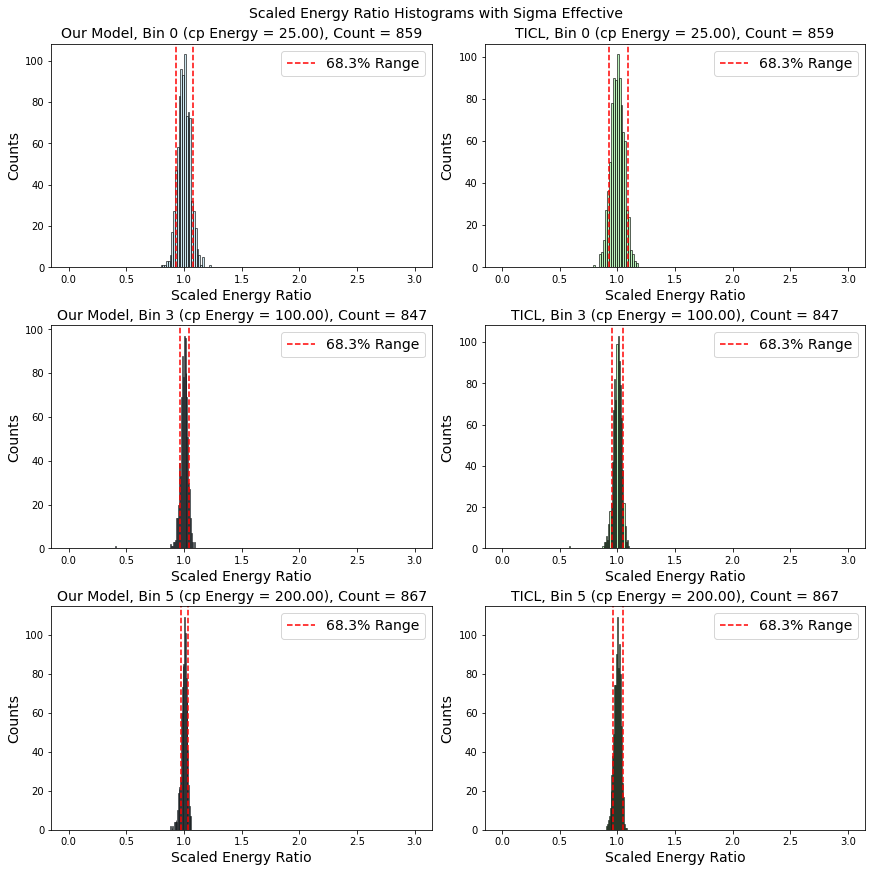

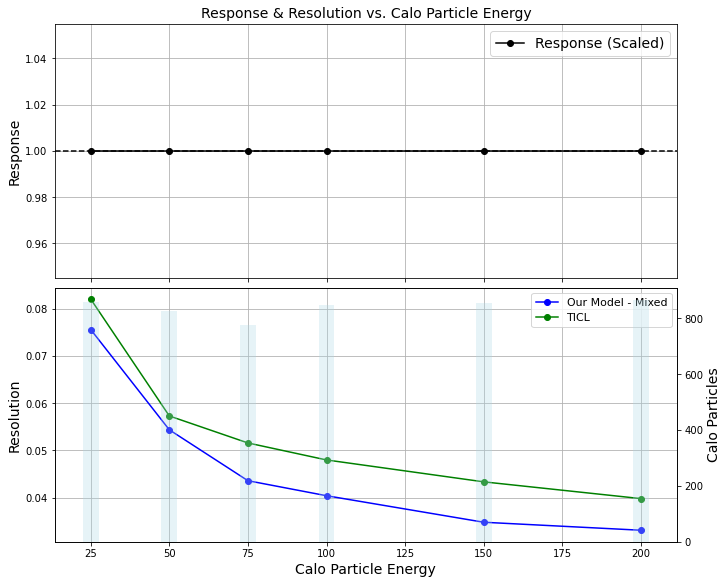

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define allowed energies for CaloParticles
allowed_energies = np.array([25, 50, 75, 100, 150, 200])

def process_cp_dataframe(df):
    """Convert columns to numeric and keep only events with exactly one calo particle id (selecting the row with highest shared_energy if needed)."""
    df = df.copy()
    for col in ['cp_id', 'cp_energy', 'energy_ratio', 'shared_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # For each (event_index, cp_id), keep the row with the highest shared_energy.
    df_cp = df.loc[df.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    
    # Only keep events that have exactly one unique cp_id.
    valid_events = df_cp.groupby('event_index')['cp_id'].nunique()
    valid_events = valid_events[valid_events == 1].index
    df_cp = df_cp[df_cp['event_index'].isin(valid_events)]
    
    return df_cp

# Process each DataFrame
df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)
# Removed processing for df_CL_pi

# Map each cp_energy to a bin based on allowed energies
energy_to_bin = {energy: idx for idx, energy in enumerate(allowed_energies)}
df_CL_cp['energy_bin'] = df_CL_cp['cp_energy'].map(energy_to_bin)
df_TICL_cp['energy_bin'] = df_TICL_cp['cp_energy'].map(energy_to_bin)
# Removed mapping for df_CL_pi

def compute_scaled_sigma_effective(df, num_bins):
    """
    For each energy bin, scale the energy_ratio data so the mean is 1, then compute the sigma effective
    as the width of the narrowest window covering 68.3% of the data.
    """
    effective_mean_scaled, sigma_eff_scaled, counts = [], [], []
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
            sorted_data = np.sort(scaled_data)
            n_points = len(sorted_data)
            window_size = max(1, int(0.683 * n_points))
            min_width = np.inf
            best_range = (None, None)
            for i in range(n_points - window_size):
                width = sorted_data[i + window_size] - sorted_data[i]
                if width < min_width:
                    min_width = width
                    best_range = (sorted_data[i], sorted_data[i + window_size])
            mu_eff = (best_range[0] + best_range[1]) / 2 
            sigma_eff_val = (best_range[1] - best_range[0]) / np.sqrt(2)
            effective_mean_scaled.append(mu_eff)
            sigma_eff_scaled.append(sigma_eff_val)
        else:
            effective_mean_scaled.append(np.nan)
            sigma_eff_scaled.append(np.nan)
    return np.array(effective_mean_scaled), np.array(sigma_eff_scaled), np.array(counts)

n_bins = len(allowed_energies)
scaled_fitted_mean_CL, scaled_sigma_eff_CL, counts_CL = compute_scaled_sigma_effective(df_CL_cp, n_bins)
scaled_fitted_mean_TICL, scaled_sigma_eff_TICL, counts_TICL = compute_scaled_sigma_effective(df_TICL_cp, n_bins)
# Removed calculation for df_CL_pi

# Plot scaled histograms for selected bins
selected_bins = [0, n_bins // 2, n_bins - 1]
fig_hist, axs = plt.subplots(len(selected_bins), 2, figsize=(12, 4 * len(selected_bins)), constrained_layout=True)

for i, b in enumerate(selected_bins):
    for df, mean_scaled, sigma_scaled, label, color, ax in zip(
            [df_CL_cp, df_TICL_cp],
            [scaled_fitted_mean_CL, scaled_fitted_mean_TICL],
            [scaled_sigma_eff_CL, scaled_sigma_eff_TICL],
            ['Our Model', 'TICL'],
            ['lightblue', 'lightgreen'],
            axs[i] if len(selected_bins) > 1 else [axs]):
        
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
        else:
            scaled_data = bin_data
        
        ax.hist(scaled_data, bins='auto', range=(0, 3), color=color, alpha=0.6, edgecolor='k')
        ax.axvline(mean_scaled[b] - sigma_scaled[b], color='r', linestyle='--', label='68.3% Range')
        ax.axvline(mean_scaled[b] + sigma_scaled[b], color='r', linestyle='--')
        ax.set_title(f'{label}, Bin {b} (cp Energy = {allowed_energies[b]:.2f}), Count = {len(scaled_data)}', fontsize=14)
        ax.set_xlabel('Scaled Energy Ratio', fontsize=14)
        ax.set_ylabel('Counts', fontsize=14)
        ax.legend(fontsize=14)

plt.suptitle('Scaled Energy Ratio Histograms with Sigma Effective', fontsize=14)
plt.show()

# Plot response (fixed at 1) and resolution vs. cp energy
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

# Plot response
ax_resp.plot(allowed_energies, np.ones(n_bins), 'ko-', label='Response (Scaled)')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response', fontsize=14)
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy', fontsize=14)
ax_resp.legend(fontsize=14)
ax_resp.grid()
ax_resp.tick_params(labelsize=10)

# Plot resolution with the requested line styles:
ax_res.plot(allowed_energies, scaled_sigma_eff_CL, 'bo-', label='Our Model - Mixed')      # Blue full line with circle markers.
ax_res.plot(allowed_energies, scaled_sigma_eff_TICL, 'go-', label='TICL')                   # Green full line with circle markers.
# Removed the df_CL_pi curve
ax_res.set_xlabel('Calo Particle Energy', fontsize=14)
ax_res.set_ylabel('Resolution', fontsize=14)

ax_res.legend(fontsize=11)
ax_res.grid()
ax_res.tick_params(labelsize=10)

ax_res2 = ax_res.twinx()
ax_res2.bar(allowed_energies, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles', fontsize=14)
ax_res2.tick_params(labelsize=10)

plt.show()


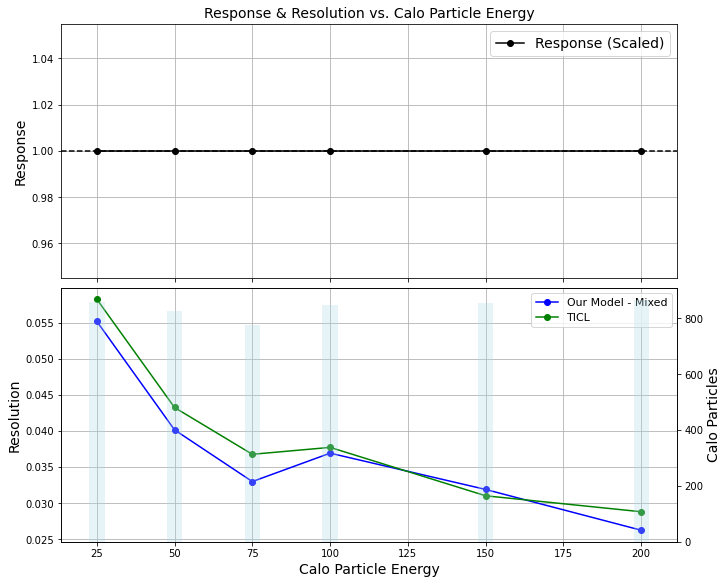

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define allowed energies for CaloParticles
allowed_energies = np.array([25, 50, 75, 100, 150, 200])

def process_cp_dataframe(df):
    """Convert columns to numeric and keep only events with exactly one calo particle id (selecting the row with highest shared_energy if needed)."""
    df = df.copy()
    for col in ['cp_id', 'cp_energy', 'energy_ratio', 'shared_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # For each (event_index, cp_id), keep the row with the highest shared_energy.
    df_cp = df.loc[df.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    
    # Only keep events that have exactly one unique cp_id.
    valid_events = df_cp.groupby('event_index')['cp_id'].nunique()
    valid_events = valid_events[valid_events == 1].index
    df_cp = df_cp[df_cp['event_index'].isin(valid_events)]
    
    return df_cp

# Process each DataFrame
df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# Map each cp_energy to a bin based on allowed energies
energy_to_bin = {energy: idx for idx, energy in enumerate(allowed_energies)}
df_CL_cp['energy_bin'] = df_CL_cp['cp_energy'].map(energy_to_bin)
df_TICL_cp['energy_bin'] = df_TICL_cp['cp_energy'].map(energy_to_bin)

def compute_scaled_sigma_effective(df, num_bins):
    """
    For each energy bin, scale the energy_ratio data so the mean is 1, then compute the standard deviation.
    """
    sigma_eff_scaled, counts = [], []
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
            sigma_eff_val = np.std(scaled_data)
            sigma_eff_scaled.append(sigma_eff_val)
        else:
            sigma_eff_scaled.append(np.nan)
    return np.array(sigma_eff_scaled), np.array(counts)

n_bins = len(allowed_energies)
scaled_sigma_eff_CL, counts_CL = compute_scaled_sigma_effective(df_CL_cp, n_bins)
scaled_sigma_eff_TICL, counts_TICL = compute_scaled_sigma_effective(df_TICL_cp, n_bins)

# ------------------------------------------
# Plot Response & Resolution vs. CaloParticle Energy
# ------------------------------------------
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)

# Plot response
ax_resp.plot(allowed_energies, np.ones(n_bins), 'ko-', label='Response (Scaled)')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response', fontsize=14)
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy', fontsize=14)
ax_resp.legend(fontsize=14)
ax_resp.grid()
ax_resp.tick_params(labelsize=10)

# Plot resolution with the requested line styles:
ax_res.plot(allowed_energies, scaled_sigma_eff_CL, 'bo-', label='Our Model - Mixed')      # Blue full line with circle markers.
ax_res.plot(allowed_energies, scaled_sigma_eff_TICL, 'go-', label='TICL')                   # Green full line with circle markers.
ax_res.set_xlabel('Calo Particle Energy', fontsize=14)
ax_res.set_ylabel('Resolution', fontsize=14)

ax_res.legend(fontsize=11)
ax_res.grid()
ax_res.tick_params(labelsize=10)

ax_res2 = ax_res.twinx()
ax_res2.bar(allowed_energies, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles', fontsize=14)
ax_res2.tick_params(labelsize=10)

plt.show()
